In [25]:
# Carga de librerias
# ------------------
# Librerias de uso general
import holidays
from google.cloud import storage

# Manejo de datos
import numpy as np
import pandas as pd

import kagglehub
import shutil
import os

import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM  # Importación para OC-SVM
from sklearn.neighbors import LocalOutlierFactor # Importación para LOF

from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import pickle
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from math import sqrt
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import chi2

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística y series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Se importan las funciones
from sklearn.metrics import  mean_absolute_error

In [26]:
# ---------- 0. configuración ----------
CSV_PATH = "/Users/angeleduardogamarrarios/Repositorio_UDEM/MLops_AMICO/data/costs.csv"       # ajusta si hace falta
TEST_DAYS = 60               # últimos N días para test
RND_ITER = 12                # RandomizedSearchCV iteraciones (ajusta)
TS_SPLITS = 3                # TimeSeriesSplit folds (ajusta)
PERM_REPEATS = 10            # permutación (ajusta)


In [27]:
# ---------- 1. carga y limpieza básica ----------
df = pd.read_csv(CSV_PATH)

# eliminar fila de Service total y columna de total costs
df = df[df['Service'] != 'Service total']
df = df.drop('Total costs($)', axis=1)

# convertir columna de fecha en indice
df['Service'] = pd.to_datetime(df['Service'])
df = df.rename(columns={'Service':'date'}).sort_values('date').set_index('date')

# forzar numérico y revisar columnas
df = df.apply(pd.to_numeric, errors='coerce')
num_cols = df.columns.tolist()

print("Filas:", len(df), "Columnas:", num_cols)

Filas: 351 Columnas: ['Relational Database Service($)', 'EC2-Instances($)', 'FSx($)', 'Elastic File System($)', 'EC2-Other($)', 'CloudWatch($)', 'S3($)', 'Elastic Load Balancing($)', 'Backup($)', 'Key Management Service($)', 'DataSync($)', 'Secrets Manager($)', 'Resilience Hub($)']


In [28]:
# ---------- 2. EDA rápido (resumen + skew + patrón semanal) ----------
print("\nResumen estadístico:")
print(df.describe().T)

skewness = df.skew().sort_values(ascending=False)
print("\nSkewness (top):")
print(skewness.head(10))

weekly_mean = df.groupby(df.index.day_name()).mean()
print("\nMedia por día de la semana (muestra):")
print(weekly_mean.head())


Resumen estadístico:
                                count       mean        std           min  \
Relational Database Service($)  351.0  97.240692  87.975006  1.491792e+01   
EC2-Instances($)                329.0  71.525192  25.109641  5.154986e-01   
FSx($)                          351.0  14.678272   1.855596  1.208052e+01   
Elastic File System($)          351.0   8.064240   6.456387  1.786584e+00   
EC2-Other($)                    351.0   6.076750   2.900253  3.117944e-01   
CloudWatch($)                   351.0   4.398582   7.681060  3.109096e-03   
S3($)                           351.0   2.218248   0.787167  1.023371e+00   
Elastic Load Balancing($)       351.0   2.162289   0.004710  2.160000e+00   
Backup($)                       350.0   1.514773   1.210465  2.810710e-01   
Key Management Service($)       351.0   0.260617   0.032317  2.263914e-01   
DataSync($)                     119.0   0.286251   1.415347  6.440000e-08   
Secrets Manager($)              349.0   0.000513   0.0

In [29]:
# ---------- 3. imputación ----------
# Strategy: cambiar a 0 los valores nulos
df_imputed = df.fillna(0)

El Box-Cox selectivo aplica la transformación Box-Cox solo a las variables no normales y positivas, dejando intactas las que ya siguen una distribución aproximadamente normal.
En resumen:
Evalúa la normalidad de cada variable (por ejemplo, con Shapiro-Wilk o D’Agostino).
A las que no son normales y tienen valores > 0, les aplica
El resultado reduce asimetría y varianza, haciendo que las variables sean más gaussianas sin distorsionar las que ya lo eran.
Es “selectivo” porque solo transforma donde es necesario, evitando sobreajustar el resto de las columnas.

In [30]:
# ---------- 4. Box-Cox selectivo para normalizar las varibles ----------
# Aplicar Box-Cox solo a columnas muy sesgadas (skew > 1)
skewed_cols = skewness[skewness > 1].index.tolist()
df_bc = df_imputed.copy()

for c in skewed_cols:
    # Box-Cox exige valores > 0. si hay ceros o negativos shift pequeño
    min_val = df_bc[c].min()
    shift = 0.0 if min_val > 0 else abs(min_val) + 1e-6
    try:
        transformed, lam = boxcox(df_bc[c] + shift)
        df_bc[c] = transformed
        print(f"Box-Cox aplicado a {c}, lambda={lam:.4f}")
    except Exception as e:
        # fallback log1p si falla
        df_bc[c] = np.log1p(df_bc[c] + shift)
        print(f"Box-Cox falló en {c}, aplicado log1p")


Box-Cox aplicado a Secrets Manager($), lambda=0.3130
Box-Cox aplicado a DataSync($), lambda=-0.7391
Box-Cox aplicado a Elastic Load Balancing($), lambda=-693.3143
Box-Cox aplicado a Relational Database Service($), lambda=-0.0614
Box-Cox aplicado a CloudWatch($), lambda=0.0712
Box-Cox aplicado a Key Management Service($), lambda=-4.2383


Ese código realiza una normalización estandarizada (Z-score), pero de forma separada por cada día de la semana.
En concreto:
Usa StandardScaler() → aplica la fórmula
(resta la media y divide entre la desviación estándar).
Lo hace por grupos de day_of_week, es decir, calcula media y desviación distintas para cada día (lunes, martes, etc.).
👉 En resumen: normalización Z-score diaria por día de la semana, ajustando cada grupo a media = 0 y desviación estándar = 1.

In [31]:
# ---------- 5. normalización por día de la semana ----------
df_bc['day_of_week'] = df_bc.index.day_name()
scaled = df_bc.copy()
features = [c for c in num_cols]  # lista de features reales

for day in scaled['day_of_week'].unique():
    mask = scaled['day_of_week'] == day
    if mask.sum() < 2:
        # si no hay suficientes ejemplos para el día, omitir
        continue
    scaler = StandardScaler()
    scaled.loc[mask, features] = scaler.fit_transform(scaled.loc[mask, features])


## Etiquetar el dataframe Scaled si es no Outliers

Umbral fijo de distancia de Mahalanobis: 4.20

Conteo de outliers detectados:
is_outlier_mahalanobis
No    339
Si     12
Name: count, dtype: int64


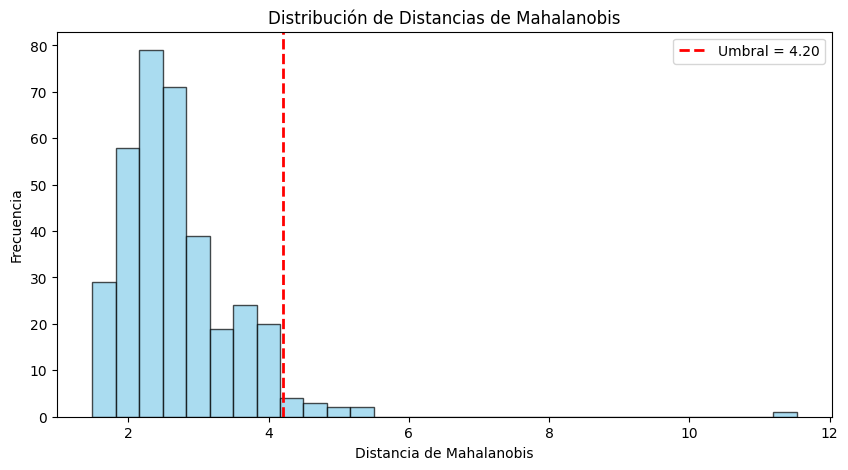

In [32]:
# 2. Definir las columnas numéricas (excluimos 'mahalanobis_distance' previa y no numéricas)
numerical_cols = [
    'Relational Database Service($)',
    'EC2-Instances($)',
    'Elastic File System($)',
    'EC2-Other($)',
    'CloudWatch($)',
    'S3($)',
    'Backup($)',
    'Key Management Service($)'
]

# 3. Extraer los datos numéricos
X_scaled = scaled[numerical_cols].values

# 4. Calcular matriz de covarianza y pseudo-inversa
covariance_matrix = np.cov(X_scaled.T)
inv_covariance_matrix = np.linalg.pinv(covariance_matrix)

# 5. Calcular el vector media
mean_vector = np.mean(X_scaled, axis=0)

# 6. Definir el umbral manual
threshold = 4.2
print(f"Umbral fijo de distancia de Mahalanobis: {threshold:.2f}")

# 7. Función para calcular la distancia de Mahalanobis
def mahalanobis_distance(x, mean, inv_cov):
    diff = x - mean
    return np.sqrt(diff.dot(inv_cov).dot(diff.T))

# 8. Calcular las distancias
scaled['mahalanobis_distance'] = [
    mahalanobis_distance(row, mean_vector, inv_covariance_matrix) for row in X_scaled
]

# 9. Clasificar los outliers (distancia > 5)
scaled['is_outlier_mahalanobis'] = np.where(
    scaled['mahalanobis_distance'] > threshold, 'Si', 'No'
)

# 10. Resumen
print("\nConteo de outliers detectados:")
print(scaled['is_outlier_mahalanobis'].value_counts())

# 11. Histograma de distancias
plt.figure(figsize=(10, 5))
plt.hist(scaled['mahalanobis_distance'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral = {threshold:.2f}')
plt.title('Distribución de Distancias de Mahalanobis')
plt.xlabel('Distancia de Mahalanobis')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# 12. Gráfico temporal (si existe columna de fecha)
if 'date' in scaled.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(pd.to_datetime(scaled['date']), scaled['mahalanobis_distance'], label='Mahalanobis Distance')
    plt.axhline(threshold, color='red', linestyle='--', label=f'Umbral ({threshold:.2f})')
    plt.scatter(
        pd.to_datetime(scaled.loc[scaled['is_outlier_mahalanobis'] == 'Si', 'date']),
        scaled.loc[scaled['is_outlier_mahalanobis'] == 'Si', 'mahalanobis_distance'],
        color='red', label='Outliers'
    )
    plt.title('Detección de Outliers por Fecha (Distancia > 5)')
    plt.xlabel('Fecha')
    plt.ylabel('Distancia de Mahalanobis')
    plt.legend()
    plt.show()



In [33]:
# ---------- 10. exportar resultados ----------
scaled.to_csv("scaled_results.csv")

In [34]:
# Define el número de días para la prueba y los días que deseas para el entrenamiento
TEST_DAYS = 90
TRAIN_DAYS_WINDOW = 90  # Días del entrenamiento desde el 1 de diciembre del 2024

# ---------- 6. División train/test temporal y ventana de entrenamiento ----------

# 6.1. Calcular la fecha de división (inicio del conjunto de prueba)
split_date = scaled.index.max() - pd.Timedelta(days=TEST_DAYS)

# 6.2. Calcular la fecha de inicio del entrenamiento
train_start_date = split_date - pd.Timedelta(days=TRAIN_DAYS_WINDOW)

# 6.3. Filtrar el conjunto de entrenamiento:
# Solo los días dentro de la ventana y sin outliers
train_df = scaled[
    (scaled.index >= train_start_date) &
    (scaled.index < split_date) &
    (scaled['is_outlier_mahalanobis'] == 'No')
].drop(columns=['day_of_week'])

# 6.4. Filtrar el conjunto de prueba (sin cambios)
test_df = scaled[
    scaled.index >= split_date
].drop(columns=['day_of_week'])

# 6.5. Separar variables predictoras (X) y variable objetivo (y)
X_train = train_df.drop(columns=['is_outlier_mahalanobis','mahalanobis_distance','FSx($)', 'Elastic Load Balancing($)', 'Resilience Hub($)','DataSync($)','Secrets Manager($)']).values
y_train = train_df['is_outlier_mahalanobis'].values

X_test = test_df.drop(columns=['is_outlier_mahalanobis','mahalanobis_distance','FSx($)', 'Elastic Load Balancing($)', 'Resilience Hub($)','DataSync($)','Secrets Manager($)']).values
y_test = test_df['is_outlier_mahalanobis'].values

# 6.6. Obtener nombres de columnas
cols = train_df.drop(columns=['is_outlier_mahalanobis','mahalanobis_distance','FSx($)', 'Elastic Load Balancing($)', 'Resilience Hub($)','DataSync($)','Secrets Manager($)']).columns.tolist()

# 6.7. Mostrar información
print(f"Fecha de Inicio de Entrenamiento: {train_start_date.date()}")
print(f"Fecha de División (Inicio Test): {split_date.date()}")
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"y_train: {len(y_train)} valores, y_test: {len(y_test)} valores")


Fecha de Inicio de Entrenamiento: 2024-11-18
Fecha de División (Inicio Test): 2025-02-16

Train shape: (86, 8), Test shape: (91, 8)
y_train: 86 valores, y_test: 91 valores


Isolation Forest (El Enfoque Robusto)
El Isolation Forest es rápido, escalable y muy robusto para datos multivariados con muchos outliers.

In [35]:
# Copia del DataFrame de entrenamiento (por si se necesita en otros modelos)
contamination_factor = 0.001

# 1. Entrenar el modelo Isolation Forest
iso_forest = IsolationForest(
    n_estimators=10,
        max_samples=0.2,
        contamination=contamination_factor,
        max_features=1,
        random_state=42,
        bootstrap=False,
        n_jobs=-1
).fit(X_train)

# 2. Definir el mapeo de etiquetas ('No' = 0, 'Si' = 1)
mapeo_etiquetas = {'No': 0, 'Si': 1}

# 3. Convertir y_test a valores numéricos (asegurando que es Series)
y_test_numerica = pd.Series(y_test).map(mapeo_etiquetas).astype(int)

# 4. Obtener predicciones del modelo (-1 = outlier, 1 = inlier)
prediction = iso_forest.predict(X_test)

# 5. Convertir las predicciones a formato 0/1 para comparación
# (-1 se considera 'outlier' → 1)
pred = np.where(prediction == -1, 1, 0)

# 6. Generar reporte de clasificación
print(classification_report(y_test_numerica, pred))

              precision    recall  f1-score   support

           0       0.90      0.52      0.66        85
           1       0.02      0.17      0.04         6

    accuracy                           0.49        91
   macro avg       0.46      0.34      0.35        91
weighted avg       0.84      0.49      0.62        91



Local Outlier Factor (LOF) LOF es un modelo basado en la densidad. Mide cuán aislado está un punto con respecto a sus vecinos más cercanos. Un score LOF mucho mayor que 1 indica una anomalía.

In [36]:
# --- CONFIGURACIÓN DEL MODELO ---
n_neighbors = 20
contamination_factor = 0.01

# Inicializar el modelo LOF (modo "novelty" para predecir en test)
lof = LocalOutlierFactor(
    n_neighbors=n_neighbors,
    contamination=contamination_factor,
    novelty=True
).fit(X_train)

# 1. Definir el mapeo
mapeo_etiquetas = {'No': 0, 'Si': 1}

# 2. Convertir y_test a pandas Series si es un array
if isinstance(y_test, np.ndarray):
    y_test = pd.Series(y_test)

# 3. Mapear etiquetas verdaderas a valores numéricos
y_true_numerica = y_test.map(mapeo_etiquetas).astype(int)

# 4. Predicción del modelo
prediction = lof.predict(X_test)

# LocalOutlierFactor devuelve: 1 = normal, -1 = outlier
pred = np.where(prediction == -1, 1, 0)

# 5. Evaluar el modelo
print(classification_report(y_true_numerica, pred))


              precision    recall  f1-score   support

           0       0.87      0.24      0.37        85
           1       0.04      0.50      0.08         6

    accuracy                           0.25        91
   macro avg       0.46      0.37      0.23        91
weighted avg       0.82      0.25      0.35        91



##Modelar con OC-SVM

In [37]:
# Entrenar el modelo One-Class SVM
One_Class_SVM = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto').fit(X_train)

# 1. Definir el mapeo de etiquetas
mapeo_etiquetas = {'No': 0, 'Si': 1}

# 2. Convertir y_test a Series si es un array
if isinstance(y_test, np.ndarray):
    y_test = pd.Series(y_test)

# 3. Mapear etiquetas a valores numéricos
y_true_numerica = y_test.map(mapeo_etiquetas).astype(int)

# 4. Hacer predicciones
prediction = One_Class_SVM.predict(X_test)

# One-Class SVM devuelve 1 para normal y -1 para outlier
pred = np.where(prediction == -1, 1, 0)

# 5. Evaluar el modelo
print(classification_report(y_true_numerica, pred))


              precision    recall  f1-score   support

           0       1.00      0.09      0.17        85
           1       0.07      1.00      0.13         6

    accuracy                           0.15        91
   macro avg       0.54      0.55      0.15        91
weighted avg       0.94      0.15      0.17        91



##Encontrar los mejores Hiperparametros con Optuna para IsolationForest


In [46]:
def objective(trial):
    """
    Función objetivo para Optuna: Define el espacio de búsqueda y devuelve el F1-score ponderado.
    """
    
    # 1. Definir el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 10, 600)
    max_samples_float = trial.suggest_float('max_samples', 0.1, 1.0, log=True)
    
    # Rango de contaminación basado en tus datos (~0.0188)
    contamination_factor = trial.suggest_float('contamination', 0.001, 0.1) 
    
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    
    # 2. Inicializar y entrenar el modelo
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples_float,
        contamination=contamination_factor,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    
    iso_forest.fit(X_train)
    
    # 3. Predicción y mapeo a etiquetas 0 y 1
    prediction = iso_forest.predict(X_test)
    # Mapeo: -1 (anomalía) -> 1, 1 (normal) -> 0
    pred = np.where(prediction == -1, 1, 0)
    
    # 4. Cálculo de la métrica objetivo: F1-score ponderado
    # Esta métrica es más robusta para conjuntos desequilibrados.
    f1_weighted = f1_score(y_test_numerica, pred, average='weighted', zero_division=0)
    
    return f1_weighted

# 5. Configurar y ejecutar el estudio de Optuna
# study_name: Nombre del estudio
# direction='maximize': Intentamos maximizar la métrica
study = optuna.create_study(direction='maximize', study_name="IsolationForest_Hyperparam_Opt")

# n_trials: Número de veces que Optuna probará una combinación de hiperparámetros
study.optimize(objective, n_trials=200) 

# 6. Imprimir los resultados
print("\n--- Resultados de Optuna ---")
print(f"Mejor F1-Score Ponderado: {study.best_value:.4f}")
print("Mejores Hiperparámetros:")
print(study.best_params)

# 7. Evaluar el mejor modelo encontrado
best_iso_forest = IsolationForest(**study.best_params, random_state=42, n_jobs=-1)
best_iso_forest.fit(X_train)
best_prediction = best_iso_forest.predict(X_test)
best_pred = np.where(best_prediction == -1, 1, 0)

# 8. Reporte de Clasificación Corregido
# El parámetro 'labels=[0, 1]' fuerza a classification_report a esperar ambas clases.
print("\n--- Reporte de Clasificación con Mejores Hiperparámetros (Corregido) ---")
print(classification_report(
    y_test_numerica, 
    best_pred, 
    target_names=['Clase 0 (Normal)', 'Clase 1 (Anomalía)'], 
    labels=[0, 1], # <--- ESTA ES LA CORRECCIÓN CLAVE
    zero_division=0
))

[I 2025-11-07 19:02:18,120] A new study created in memory with name: IsolationForest_Hyperparam_Opt
[I 2025-11-07 19:02:18,303] Trial 0 finished with value: 0.40596546310832016 and parameters: {'n_estimators': 228, 'max_samples': 0.3560538550870589, 'contamination': 0.01928571140682623, 'max_features': 0.7759068247831253, 'bootstrap': False}. Best is trial 0 with value: 0.40596546310832016.
[I 2025-11-07 19:02:18,320] Trial 1 finished with value: 0.4445094166054581 and parameters: {'n_estimators': 17, 'max_samples': 0.5466157695088238, 'contamination': 0.07772274988191014, 'max_features': 0.8164585256737796, 'bootstrap': True}. Best is trial 1 with value: 0.4445094166054581.
[I 2025-11-07 19:02:18,530] Trial 2 finished with value: 0.5045492142266336 and parameters: {'n_estimators': 325, 'max_samples': 0.2865753049615865, 'contamination': 0.02722334271096836, 'max_features': 0.8467908376947844, 'bootstrap': True}. Best is trial 2 with value: 0.5045492142266336.
[I 2025-11-07 19:02:18,61


--- Resultados de Optuna ---
Mejor F1-Score Ponderado: 0.9038
Mejores Hiperparámetros:
{'n_estimators': 32, 'max_samples': 0.19598109231732658, 'contamination': 0.01879664621352344, 'max_features': 0.864140212788823, 'bootstrap': True}

--- Reporte de Clasificación con Mejores Hiperparámetros (Corregido) ---
                    precision    recall  f1-score   support

  Clase 0 (Normal)       0.94      0.96      0.95        85
Clase 1 (Anomalía)       0.25      0.17      0.20         6

          accuracy                           0.91        91
         macro avg       0.60      0.57      0.58        91
      weighted avg       0.90      0.91      0.90        91



In [39]:
import joblib

# Inicializar y entrenar el modelo
iso_forest = IsolationForest(
        n_estimators=10,
        max_samples=0.29775849710689867,
        contamination=0.0717176502157413,
        max_features=0.5310605708595397,
        random_state=42,
        bootstrap=False,
        n_jobs=-1
    ).fit(X_train)

# 2. Definir el mapeo de etiquetas ('No' = 0, 'Si' = 1)
mapeo_etiquetas = {'No': 0, 'Si': 1}

# 3. Convertir y_test a valores numéricos (asegurando que es Series)
y_test_numerica = pd.Series(y_test).map(mapeo_etiquetas).astype(int)

# 4. Obtener predicciones del modelo (-1 = outlier, 1 = inlier)
prediction = iso_forest.predict(X_test)

# 5. Convertir las predicciones a formato 0/1 para comparación
# (-1 se considera 'outlier' → 1)
pred = np.where(prediction == -1, 1, 0)

# 6. Generar reporte de clasificación
print(classification_report(y_test_numerica, pred))

# Guardar el modelo entrenado
joblib.dump(iso_forest, 'modelo_entrenado_amico.pkl')

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        85
           1       0.33      0.17      0.22         6

    accuracy                           0.92        91
   macro avg       0.64      0.57      0.59        91
weighted avg       0.90      0.92      0.91        91



['modelo_entrenado_amico.pkl']

In [40]:
# ---------- 7. búsqueda de hiperparámetros ----------
# scoring personalizado: media de decision_function (cuanto mayor, mejor)
def scoring_fn(estimator, X, y=None):
    return float(np.mean(estimator.decision_function(X)))

iso = IsolationForest(random_state=42)

param_dist = {
    'n_estimators': [10,50, 100, 200, 300],
    'max_samples': [0.2,0.3,0.5, 0.7, 0.9, 'auto'],
    'contamination': [0.001, 0.005, 0.01, 0.02, 0.05,0.071],
    'max_features': [0.5,0.53, 0.7, 1.0]
}

tscv = TimeSeriesSplit(n_splits=TS_SPLITS)
rnd = RandomizedSearchCV(iso, param_distributions=param_dist, n_iter=RND_ITER,
                         cv=tscv, random_state=42, n_jobs=-1, scoring=scoring_fn, verbose=1)
rnd.fit(X_train)

print("\nMejores parámetros (RandomizedSearch):")
print(rnd.best_params_)

# ajustar pequeño grid alrededor del mejor para refinar (GridSearch)
best = rnd.best_params_
grid = {
    'n_estimators': sorted(list({max(10, best['n_estimators']-50), best['n_estimators'], best['n_estimators']+50})),
    'max_samples': sorted(list(set([best['max_samples'] if best['max_samples']=='auto' else max(0.1, best['max_samples']-0.1), best['max_samples'], min(1.0, best['max_samples']+0.1)]))),
    'contamination': sorted(list({max(0.0005, best['contamination']/2), best['contamination'], min(0.1, best['contamination']*2)})),
    'max_features': sorted(list({max(0.1, best['max_features']-0.2), best['max_features'], min(1.0, best['max_features']+0.2)}))
}
# limpiar valores inválidos
grid['max_samples'] = [v for v in grid['max_samples'] if (isinstance(v, str) or (isinstance(v, float) and 0 < v <= 1))]

gsearch = GridSearchCV(IsolationForest(random_state=42), param_grid=grid, cv=tscv, n_jobs=-1, scoring=scoring_fn, verbose=1)
gsearch.fit(X_train)

print("\nMejores parámetros (GridSearch):")
print(gsearch.best_params_)

best_model = gsearch.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Mejores parámetros (RandomizedSearch):
{'n_estimators': 10, 'max_samples': 0.3, 'max_features': 0.7, 'contamination': 0.001}
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Mejores parámetros (GridSearch):
{'contamination': 0.0005, 'max_features': 0.49999999999999994, 'max_samples': 0.19999999999999998, 'n_estimators': 10}


In [41]:
# ---------- 8. predecir y marcar anomalías ----------
test_scores = best_model.decision_function(X_test)   # mayor => más normal
test_pred = best_model.predict(X_test)                # 1 normal, -1 anomalía
test_anomaly = np.where(test_pred == 1, 0, 1)         # 1 = anomalía (más intuitivo)

test_out = test_df.copy()
test_out['anomaly_score'] = test_scores
test_out['anomaly'] = test_anomaly

print("\nAnomalías en test (conteo):", int(test_out['anomaly'].sum()))
print(test_out[['anomaly_score','anomaly']].head(10))

# ---------- 9. importancia de features (permutación) ----------
# Usamos como 'y' las scores del modelo en train y medimos R2 del estimator.decision_function
y_train_scores = best_model.decision_function(X_train)

def scoring_fn_r2(estimator, X, y):
    return r2_score(y, estimator.decision_function(X))

perm = permutation_importance(best_model, X_train, y_train_scores, scoring=scoring_fn_r2,
                              n_repeats=PERM_REPEATS, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=cols).sort_values(ascending=False)

print("\nTop features por importancia (permutación):")
print(perm_importances.head(10))





Anomalías en test (conteo): 0
            anomaly_score  anomaly
date                              
2025-02-16       0.069230        0
2025-02-17       0.100586        0
2025-02-18       0.093144        0
2025-02-19       0.069230        0
2025-02-20       0.077936        0
2025-02-21       0.085595        0
2025-02-22       0.084685        0
2025-02-23       0.061334        0
2025-02-24       0.061334        0
2025-02-25       0.069230        0

Top features por importancia (permutación):
Key Management Service($)         0.446385
CloudWatch($)                     0.413265
EC2-Instances($)                  0.182717
Elastic File System($)            0.154213
EC2-Other($)                      0.140583
S3($)                             0.098862
Backup($)                         0.096718
Relational Database Service($)    0.076032
dtype: float64


In [42]:
# ---------- 10. exportar resultados ----------
test_out.to_csv("test_anomaly_results.csv")
perm_importances.to_csv("feature_importances_permutation.csv")
print("\nResultados guardados: test_anomaly_results.csv, feature_importances_permutation.csv")


Resultados guardados: test_anomaly_results.csv, feature_importances_permutation.csv


In [43]:
import joblib
# Guardar el modelo entrenado
joblib.dump(best_model, 'modelo_entrenado_amico_1.pkl')
modelo_cargado = joblib.load('modelo_entrenado_amico_1.pkl')
pred = modelo_cargado.predict(X_test)
print(pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Isolation forest prueba 
Mejores parámetros (RandomizedSearch):
{'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.7, 'contamination': 0.001}
Fitting 3 folds for each of 81 candidates, totalling 243 fits

In [44]:
# Inicializar y entrenar el modelo
iso_forest = IsolationForest(
        n_estimators=50,
        max_samples=0.9,
        contamination=0.001,
        max_features=0.7,
        random_state=42,
        bootstrap=False,
        n_jobs=-1
    ).fit(X_train)

# 2. Definir el mapeo de etiquetas ('No' = 0, 'Si' = 1)
mapeo_etiquetas = {'No': 0, 'Si': 1}

# 3. Convertir y_test a valores numéricos (asegurando que es Series)
y_test_numerica = pd.Series(y_test).map(mapeo_etiquetas).astype(int)

# 4. Obtener predicciones del modelo (-1 = outlier, 1 = inlier)
prediction = iso_forest.predict(X_test)

# 5. Convertir las predicciones a formato 0/1 para comparación
# (-1 se considera 'outlier' → 1)
pred = np.where(prediction == -1, 1, 0)

# 6. Generar reporte de clasificación
print(classification_report(y_test_numerica, pred))


              precision    recall  f1-score   support

           0       0.91      0.61      0.73        85
           1       0.03      0.17      0.05         6

    accuracy                           0.58        91
   macro avg       0.47      0.39      0.39        91
weighted avg       0.85      0.58      0.69        91



## Isolation forest prueba 
Mejores parámetros (GridSearch):
{'contamination': 0.0005, 'max_features': 0.8999999999999999, 'max_samples': 0.8, 'n_estimators': 10}

In [45]:
# Inicializar y entrenar el modelo
iso_forest = IsolationForest(
        n_estimators=10,
        max_samples=0.8,
        contamination=0.0005,
        max_features=0.8999999999999999,
        random_state=42,
        n_jobs=-1
    ).fit(X_train)

# 2. Definir el mapeo de etiquetas ('No' = 0, 'Si' = 1)
mapeo_etiquetas = {'No': 0, 'Si': 1}

# 3. Convertir y_test a valores numéricos (asegurando que es Series)
y_test_numerica = pd.Series(y_test).map(mapeo_etiquetas).astype(int)

# 4. Obtener predicciones del modelo (-1 = outlier, 1 = inlier)
prediction = iso_forest.predict(X_test)

# 5. Convertir las predicciones a formato 0/1 para comparación
# (-1 se considera 'outlier' → 1)
pred = np.where(prediction == -1, 1, 0)

# 6. Generar reporte de clasificación
print(classification_report(y_test_numerica, pred))


              precision    recall  f1-score   support

           0       0.91      0.72      0.80        85
           1       0.00      0.00      0.00         6

    accuracy                           0.67        91
   macro avg       0.46      0.36      0.40        91
weighted avg       0.85      0.67      0.75        91

